In [28]:
# Importación de librerías necesarias
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [29]:
# 1. Cargar los datos
ruta_al_archivo = 'datos_telecom_preprocesado_3.csv'  # Modificar según la ubicación del archivo
data = pd.read_csv(ruta_al_archivo)

In [30]:
# 3. Selección de características
X = data.drop(columns=['ID'])

In [31]:
# 4. Determinación del número óptimo de clusters
wcss = []
silhouette_scores = []

for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X, kmeans.labels_))

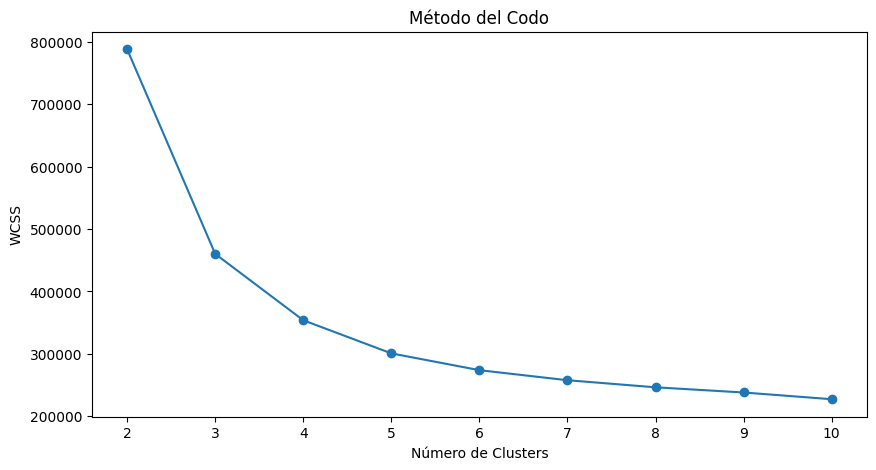

In [16]:
# Método del codo
plt.figure(figsize=(10, 5))
plt.plot(range(2, 11), wcss, marker='o')
plt.title('Método del Codo')
plt.xlabel('Número de Clusters')
plt.ylabel('WCSS')
plt.show()

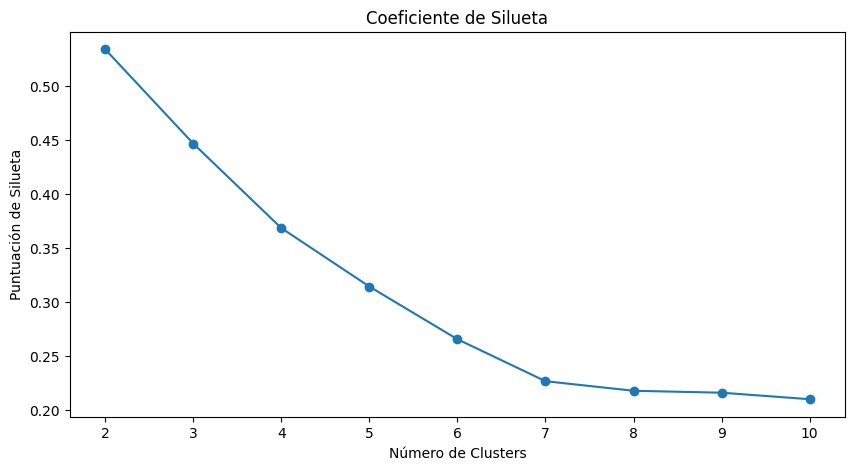

In [17]:
# Coeficiente de silueta
plt.figure(figsize=(10, 5))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Coeficiente de Silueta')
plt.xlabel('Número de Clusters')
plt.ylabel('Puntuación de Silueta')
plt.show()

In [18]:
# Seleccionar el número óptimo de clusters (ajustar según los gráficos)
n_clusters_optimo = 5

In [19]:
# 5. Entrenamiento del modelo K-Means
kmeans = KMeans(n_clusters=n_clusters_optimo, random_state=42)
data['Cluster'] = kmeans.fit_predict(X)

In [20]:
# 6. Validación del modelo
# Coeficiente de Silueta
silhouette_avg = silhouette_score(X, data['Cluster'])
print(f'Coeficiente de Silueta Promedio: {silhouette_avg:.2f}')

# Índice Calinski-Harabasz
calinski_score = calinski_harabasz_score(X, data['Cluster'])
print(f'Índice de Calinski-Harabasz: {calinski_score:.2f}')

# Índice Davies-Bouldin
davies_bouldin = davies_bouldin_score(X, data['Cluster'])
print(f'Índice Davies-Bouldin: {davies_bouldin:.2f}')

Coeficiente de Silueta Promedio: 0.31
Índice de Calinski-Harabasz: 19288.05
Índice Davies-Bouldin: 1.02


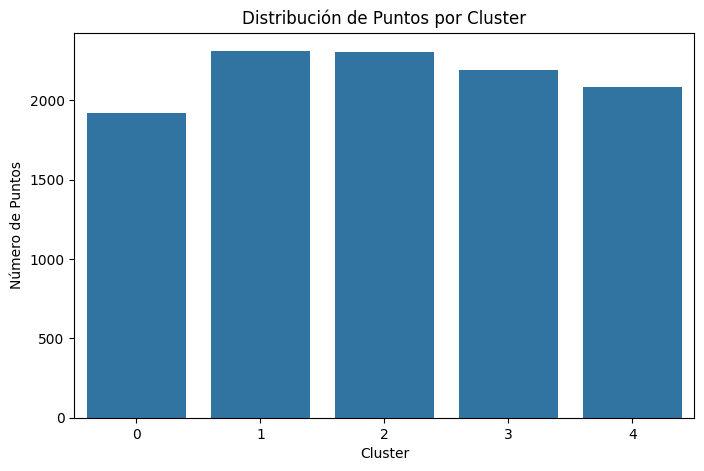

In [21]:
# Distribución de clusters
cluster_counts = data['Cluster'].value_counts()
plt.figure(figsize=(8, 5))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values)
plt.title('Distribución de Puntos por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Número de Puntos')
plt.show()

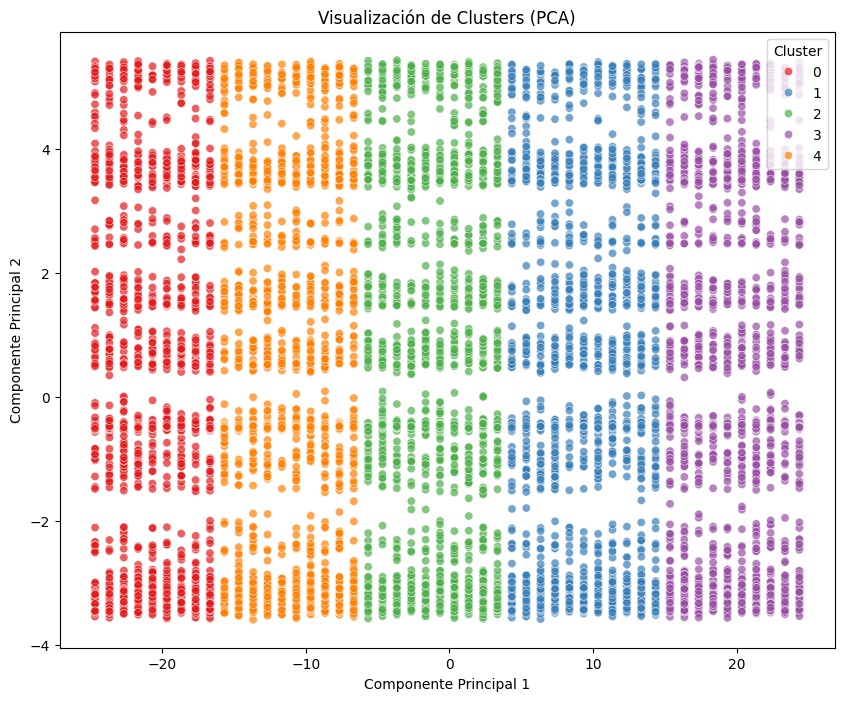

In [25]:
# 7. Visualización con PCA
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X)
data['PCA1'], data['PCA2'] = X_pca[:, 0], X_pca[:, 1]

plt.figure(figsize=(10, 8))
sns.scatterplot(data=data, x='PCA1', y='PCA2', hue='Cluster', palette='Set1', alpha=0.7)
plt.title('Visualización de Clusters (PCA)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Cluster')
plt.show()

In [26]:
# 8. Gráfico de Siluetas
def plot_silhouette(X, labels, n_clusters):
    silhouette_vals = silhouette_samples(X, labels)
    y_lower, y_upper = 0, 0
    yticks = []

    plt.figure(figsize=(10, 7))
    for i in range(n_clusters):
        cluster_silhouette_vals = silhouette_vals[labels == i]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)
        plt.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
        yticks.append((y_lower + y_upper) / 2)
        y_lower += len(cluster_silhouette_vals)

    plt.axvline(silhouette_avg, color="red", linestyle="--")
    plt.yticks(yticks, [f'Cluster {i}' for i in range(n_clusters)])
    plt.ylabel("Clusters")
    plt.xlabel("Coeficiente de Silueta")
    plt.title("Gráfico de Silueta")
    plt.show()

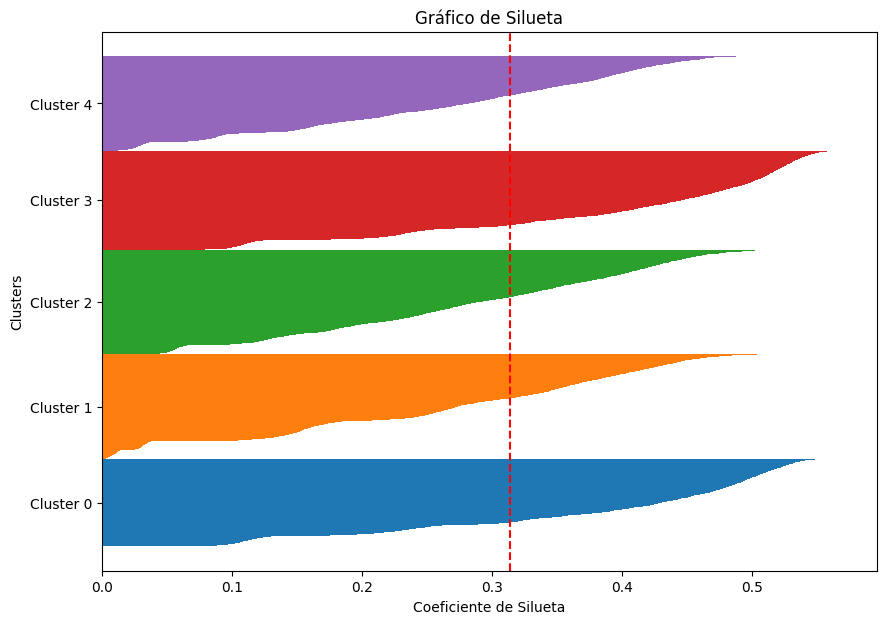

In [27]:
# Graficar siluetas
plot_silhouette(X, data['Cluster'].values, n_clusters_optimo)